# 파이썬과 함수 최적화만 사용하여 선형회귀 만들기

- 이 노트북 파일에서는 머신러닝, 딥러닝에 대한 기본 지식이 없이 심지어 머신러닝, 딥러닝 라이브러리를 사용하지 않고 선형회귀를 구현해 봅니다.

- 필요한 지식은 점과 회귀선의 차이를 줄인다는 것과 목적함수 식을 이해하는 것입니다.

- 또 사용하는 라이브러리는 구성된 목적함수를 최소화 하기 위한 `scipy.optimize.minimize`함수입니다.

- 중요한것은 최적화 이론 깊은 곳에서 일어나는 세부사항을 전혀 몰라도 괜찮다는 것입니다. 단지 사용하는 `minimize`함수가 주어진 함수의 함수값을 최소로 만들어 준다는 사실만 기억하세요.

- 그럼 시작 해보겠습니다!


## List version

### 모듈 임포트

- 파이썬 문법 시간에 배운대로 파이썬을 제대로 활용할려면 최소한의 외부 라이브러리가 필요합니다.

- 여기서는 그림을 그리기 위해 `matplotlib`와 함수를 최소화하기 위한 `minimize`함수를 임포트 하겠습니다.

In [18]:
# pip install scipy

In [19]:
import matplotlib.pyplot as plt

# minimize 임포트
from scipy.optimize import minimize

-  `minimize`함수를 사용하는 방법을 간단히 데모하겠습니다.
```python
minimize(function, ininial_value)
```

- `minimize`함수는 첫번째로 최소화 시킬 함수를 전달받고, 두번째로 함수를 최소화 시킬 시작점인 초기값을 전달 받습니다.

- 간단하게 정의할 수 있는 2차 함수를 가지고 `minimize`함수를 사용해보겠습니다.

In [20]:
# 입력 x를 받는 테스트 함수를 정의 합니다.
def f(x):
    return x**2 + 2*x + 3  # (x+1)**2 + 2

- 정의된 $x^2 + 2x + 3$은 간단한 계산으로 쉽게 최소값을 주는 $x$를 구할 수 있지만 `minimize`를 사용하는 방법을 익히기 위한 것이므로 여기서는 최소값을 모른다고 가정합니다.

- 이제 `minimize`함수에 앞서 정의한 `f`를 주고 `0.2`부터 시작해서 최소값을 찾기로 해보겠습니다.

In [21]:
result = minimize(f, 0.2)
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0
        x: [-1.000e+00]
      nit: 2
      jac: [ 2.980e-08]
 hess_inv: [[ 5.000e-01]]
     nfev: 6
     njev: 3

- 결과를 보면 두번만에 최적해애 도달했음을 알 수 있습니다. (`nit:2`로 부터 반복번수가 두 번임을 알 수 있습니다.)

- 찾고자 하는 `x`의 값은 -1입니다.

- 실제로 2차 함수의 포물선 그래프를 그려서 결과를 도식적으로 확인해보도록 하겠습니다.

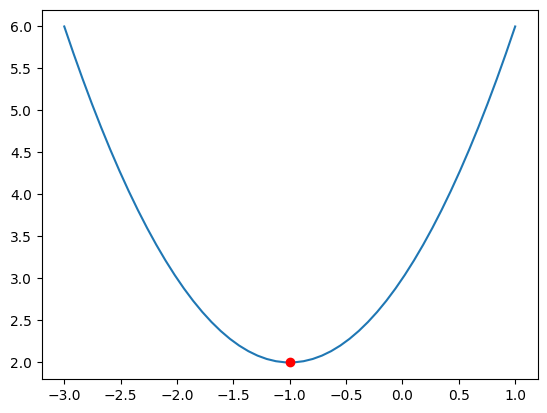

In [22]:
import numpy as np

x = np.linspace(-3, 1, 50)

def y(x):
    return x**2 + 2*x + 3

plt.plot(x, y(x))

# 최적점 표시
plt.plot(result.x[0], y(result.x[0]), 'ro')

plt.show()

- `x=-1.0`일 때 포물선의 가장 아래로 볼록한 위치가 확인됩니다.

### 목적함수 정의

- 함수를 정의하고 그 함수를 `minimize`에 넘기면 함수를 최소화 시키는 `x`를 구해준다는 것을 알았습니다.

- 이제 이 실습에서 해결해야하는 과제는 주어진 점과 회귀선의 에러 총합을 함수로 정의하고 그 함수를 `minimize`함수에 넘기는 것입니다.

- 먼저 임의의 데이터를 정의하겠습니다. 이 데이터를 온도에 따른 빙과류 판매량이라고 생각해보겠습니다.(주어진 숫자가 온도와 판매량에 적합하지 않는 숫자이지만)

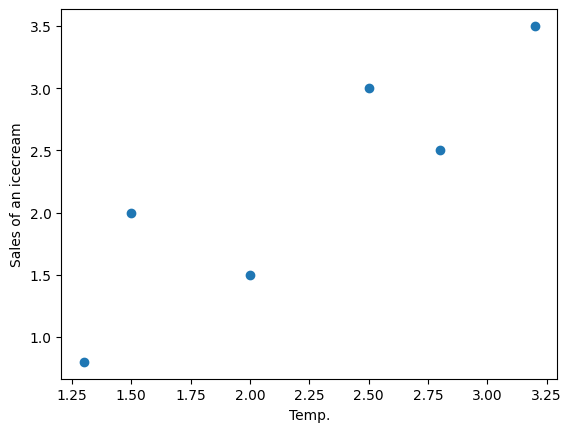

In [23]:
# list version
X = [1.3, 1.5, 2.0, 2.5, 2.8, 3.2]
y = [0.8, 2.0, 1.5, 3.0, 2.5, 3.5]

plt.plot(X, y, 'o')
plt.xlabel('Temp.')
plt.ylabel('Sales of an icecream')
plt.show()

D = {'data':X, 'target':y}

- 온도와 아이스크림 판매량 간의 관계를 직선으로 표시하고 싶습니다.

- 모델은 $ y = w_1 x + w_0 $ 될 것이며 여기서 $x$는 온도 $y$는 아이스크림 판매량입니다.

- 다음처럼 `Loss`클래스를 정의 합니다. 손실함수를 일반적인 `def func()`형태로 정의 하지 않고 클래스 형태로 정의하는 이유는 이 함수의 값을 구하기 위해서는 `X`와 `y`가 필요하기 때문입니다. 즉, 데이터가 필요합니다.

- 이 데이터를 클래스의 내부 자료로 가지고 있으면 좀 더 명확하게 손실 함수 코드를 작성할 수 있습니다.

- 손실함수 값은 다음처럼 계산됩니다.

$$
MSE = \frac{1}{2N}  \sum_{i=1}^{N} \left( \hat{y}_i - y_i \right)^2
$$

- 위 식에서 $\hat{y}_i$는 다음처럼 모델의 출력입니다.

$$
\hat{y}_i = w_1 x + w_0
$$

- 위 식으로 부터 이제는 최적화 시켜야할 변수(parameter)가 두 개라는 것을 알 수 있습니다.

- `__call__`함수를 정의해서 이 클래스로 부터 만들어진 객체가 callable하게 만들어 `minimize`함수가 마치 객체를 함수처럼 인식하도록 해야 합니다.


- 클래스에 `__call__` 함수가 작동하는 간단한 예가 다음 코드로 제시되어 있습니다.


In [28]:
# __call__ 함수 데모

class Foo:
    def __init__(self, x):
        self.x = x

    def forward(self):
        print(self.x)

    def __call__(self):
        self.forward()
        

foo = Foo(10)

- `__call__`을 잘 이용하면 `Loss` 객체를 함수처럼 사용할 수 있습니다.

- 아래 뼈대 코드의 `__call__`함수에 전달되는 `w`는 최적화 시켜야 할 파라미터가 두개 포함된 리스트입니다.

In [25]:
class Loss:
    def __init__(self, D):
        # D로 부터 내부 변수로 X, y, N을 초기화
        self.X = D['data']
        self.y = D['target']
        self.N = len(self.X)

    def __call__(self, w):
        """
        w: 매개변수 w0, w1가 포함된 리스트
        """
        loss = self.forward(w)
        return loss

    def forward(self, w):
        # 모든 점에서 발생하는 에러를 저장할 리스트를 만듭니다.
        errors = []

        # 모든 점을 순회하면서
        for x, y in zip(self.X, self.y):
            # 모델로 예측값을 구합니다.
            # y = w1 * x + w0
            y_hat = w[1]*x + w[0]

            # 예측과 정답의 차이를 제곱해서 errors 리스트에 추가합니다.
            errors.append( (y_hat - y)**2 )

        # for 문을 마치고 나면 errors에 모든 에러값이 들어 있으므로
        # 이를 모두 더하고 2N로 나눕니다.
        return sum(errors) / (2*self.N)
        ####################################################



In [26]:
# 손실 함수 객체를 만들고
loss = Loss(D)

- `loss`객체에서 적당한 값을 대입하고 함수값이 잘 구해지는지 테스트해보겠습니다.

In [27]:
loss([3, 2])

13.859166666666667

- 3, 2라는 `w1`, `w0` 값 두개를 입력하니 손실 함숫값 하나가 출력됩니다.

- 이 결과의 의미는 $2x+3$인 모델은 에러를 13.859정도 발생시킨다는 것입니다.

### 최적화

- 이제 적당히 초기 `w`값을 잡고 `minimize`함수를 실행하면 됩니다.

In [29]:
# 초기 값은 그냥 0, 0으로 잡습니다.
# 아래 numpy 버전에서 알아보겠지만 아무런 초기값을 잡아도 상관없습니다.
w = [0, 0]

# 최적화를 수행합니다.
ret = minimize(loss, w)

ret

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.09173142070806538
        x: [-3.737e-01  1.169e+00]
      nit: 8
      jac: [-4.578e-06 -6.910e-07]
 hess_inv: [[ 1.129e+01 -4.654e+00]
            [-4.654e+00  2.104e+00]]
     nfev: 27
     njev: 9

-  결과는 다음과 거의 비슷해야 합니다.
```python
x: [-0.37368979,  1.16857979]
```

- 알아낸 파라메터로 그림을 그려보면 최적의 직선이 구해졌음을 알 수 있습니다.

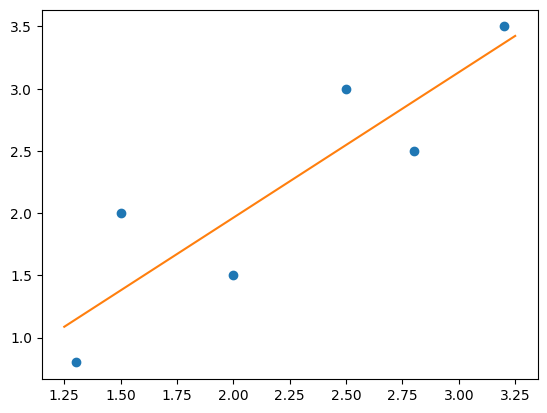

In [30]:
x = np.linspace(1.25, 3.25, 50)

w0 = ret.x[0]
w1 = ret.x[1]

y_hat = w1*x + w0


plt.plot(X, y, 'o')
plt.plot(x, y_hat)
plt.show()

- 이후 numpy로 실행한 결과와 비교 하이 위해서 `results` 사전 변수에 결과를 저장합니다.

In [31]:
results = {"list version": ret.x}

## Numpy version

- 이제 위에서 작성한 클래스를 numpy를 사용하는 버전으로 바꿔보겠습니다.

- 위 예시를 잘 확인하고 다음 순서로 코드를 작성하세요.
    - numpy 모듈을 임포트 합니다.
    - 동일한 데이터 `X`, `y`를 넘파이 어레이로 정의 합니다.
    - `Loss` 클래스의 `__call__`을 완성합니다. 주석에 힌트를 잘 보고 한 줄로 구성할 수 있으면 베스트입니다.
    - 로스 객체를 생성합니다.
    - 초기값 `w`를 정의합니다.
    - `minimize`함수를 실행해서 결과를 확인합니다.


### 연습 1

In [ ]:
# 여기에 코드를 작성하세요.
# numpy 모듈 임포트



### 연습 2

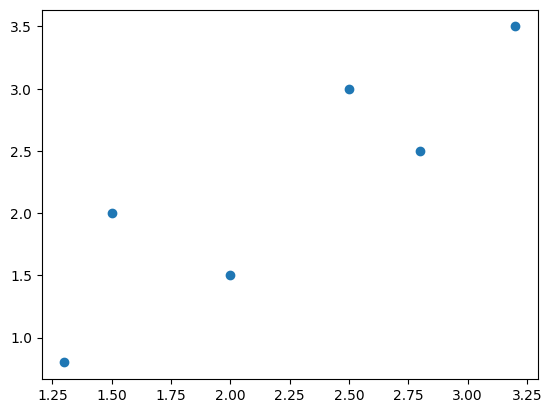

In [ ]:
# 여기에 코드를 작성하세요.
# numpy array로 데이터 재정의
X =
y =

plt.plot(X, y, 'o')
plt.show()

D = {'data':X, 'target':y}

### 연습 3

- `__call__`함수를 완성하세요.

- 브로드캐스팅을 이용하고 `np.mean()`함수를 사용해서 한줄로 코딩할 수 있습니다.

- 한 줄로 코딩하지 않아도 프로그램이 실행되는데는 아무런 문제가 없지만 이렇게 코딩함으로써 앞선 리스트를 사용한 예제와 차이점을 확인할 수 있으며 이는 numpy를 사용하는 이유를 좀 더 잘 이해할 수 있게 해줍니다.

- `np.mean` 함수의 도움말은 [여기](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)에서 확인 가능합니다.

        

In [ ]:
class Loss:
    def __init__(self, D):
        self.X = D['data']
        self.y = D['target']
        self.N = len(self.X)

    def __call__(self, w):
        ####################################################
        # 여기에 코드를 작성하세요.
        # numpy version으로 로스 함수 재정의
        # 힌트: np.mean()함수를 사용하고 브로드캐스팅을 생각하세요.
        return None
        ####################################################

loss = Loss(D)

### 연습 4

- `w` 변수에 `np.random.rand`함수를 사용하여 적당히 두 소수를 초기화 하세요.

- `np.random.rand` 함수의 도움말은 [여기](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html)에서 확인할 수 있습니다.


In [ ]:
# 여기에 코드를 작성하세요.
w = None

print(w)

[0.73926358 0.03918779]


### 연습 5

- 이제 만들어진 손실 함수 객체 `loss`와 초기값 `w`를 써서 `minimize`함수를 실행하세요.

In [ ]:
# 여기에 코드를 작성하세요.
ret = None

ret

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.09173142060173846
        x: [-3.736e-01  1.169e+00]
      nit: 7
      jac: [-2.794e-08  1.118e-07]
 hess_inv: [[ 1.136e+01 -4.679e+00]
            [-4.679e+00  2.112e+00]]
     nfev: 27
     njev: 9

### 연습 6

- 계산된 결과를 사용하여 그림을 그려봅시다.


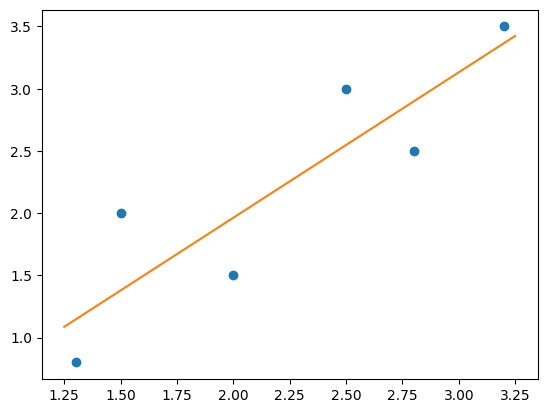

In [ ]:
# 여기에 코드를 작성하세요.



### 연습 7

- 결과를 `results`에 `numpy_version` 키로 저장합니다.

In [ ]:
# 여기에 코드를 작성하세요.



In [ ]:
# 두 결과는 거의 동일해야 함.
results

{'list version': array([-0.37368977,  1.16857978]),
 'numpy_version': array([-0.37364092,  1.1685598 ])}

## 선택 미션

- 위 코드를 이용해서 몇가지 더 연습해볼 수 있는 문제가 남아있습니다. 다음 과제에 대해서 한번 생각해봅시다.

- 주어진 점 데이터가 전체적으로 아래와 같을 때 이를 잘 피팅할 수 있는 모델(아마 3차 다항식이 될 것입니다.)을 결정한 다음, 이 모델을 위 코드를 사용해 학습하고 결과를 확인해보세요.

$$
\hat{y} = w_3 x^3 + w_2 x^2 + w_1 x + w_0
$$


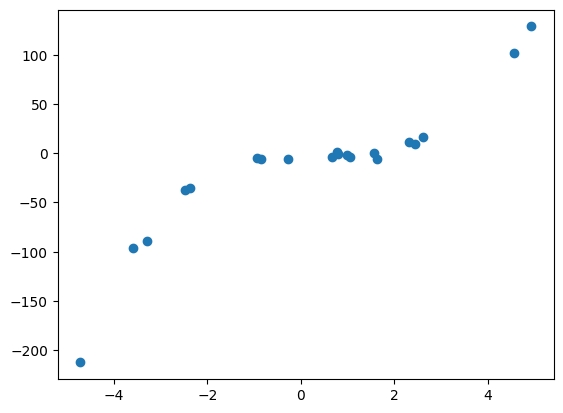

In [ ]:
np.random.seed(0)
X = 2 - 3 * np.random.normal(0, 1, 20)
y = X - 2 * (X ** 2) + 1.5 * (X ** 3) + np.random.normal(-3, 3, 20)

plt.plot(X, y, 'o')

In [ ]:
D = {'data':X, 'target':y}

In [ ]:
class Loss:
    def __init__(self, D):
        self.X = D['data']
        self.y = D['target']
        self.N = len(self.X)

    def __call__(self, w):
        ####################################################
        # 3차 다항식으로 모델을 정의하고 그 모델의 손실함수를 계산하세요.
        return None
        ####################################################

loss = Loss(D)

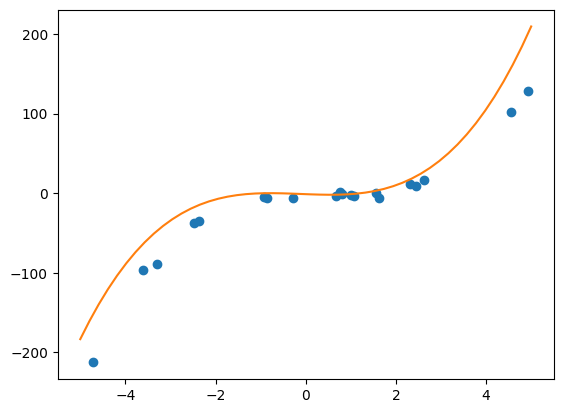

In [ ]:
# 무작위 w를 정의하고 이를 사용하여 loss를 최소화 시킨후
# 최적화된 w를 사용하여 모델을 그려 결과를 확인하세요.



## 정리

- 지금까지 배운 파이썬 문법과 모듈 사용법등을 사용하여 간단한 선형회귀 모델을 구성했습니다.

- 간단한 경우 이렇게 직접 코딩을 하여 처음부터 모델을 만들 수 있지만 대부분 경우 이미 구현된 구현체를 사용하게 됩니다.

- 앞으로 선형회귀뿐 아니라 로지스틱 회귀, 트리모델, 차원축소 등 머신러닝에서 일반적으로 사용되는 알고리즘에 대해서 자세히 알아보고 이를 구현해놓은 [scikit-learn](https://scikit-learn.org/stable/) 라이브러리에 대해서 알아보도록 하겠습니다.




